## 0. 모델 고정해서 사용하기

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout

model = Sequential([
    # Layer 1: Conv2D
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(30, 30, 3)),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Layer 2: Conv2D
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # For 10-class classification
])

# 모델 요약 출력
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

## 1. Data Centric AI 맛보기

- 22개에 대해, "Cleanlab guessed" 기준으로 변경하였음.

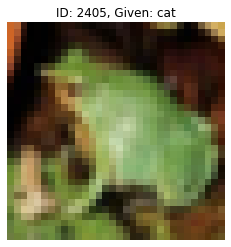

Enter correct label for ID 2405 (ex: 'frog'), or press Enter to keep as 'cat': frog
✅ Updated label to: frog



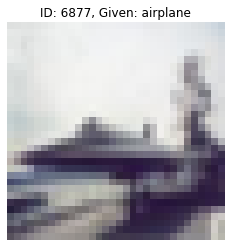

Enter correct label for ID 6877 (ex: 'frog'), or press Enter to keep as 'airplane': ship
✅ Updated label to: ship



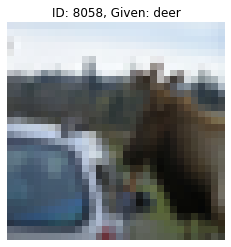

Enter correct label for ID 8058 (ex: 'frog'), or press Enter to keep as 'deer': horse
✅ Updated label to: horse



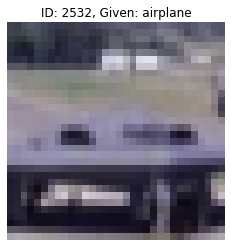

Enter correct label for ID 2532 (ex: 'frog'), or press Enter to keep as 'airplane': automobile
✅ Updated label to: automobile



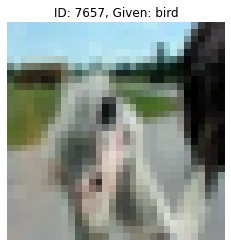

Enter correct label for ID 7657 (ex: 'frog'), or press Enter to keep as 'bird': horse
✅ Updated label to: horse



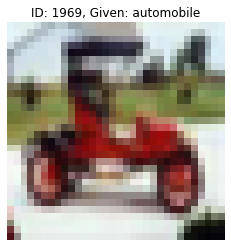

Enter correct label for ID 1969 (ex: 'frog'), or press Enter to keep as 'automobile': truck
✅ Updated label to: truck



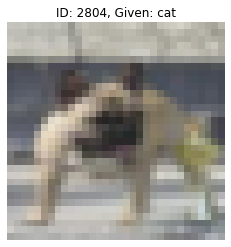

Enter correct label for ID 2804 (ex: 'frog'), or press Enter to keep as 'cat': dog
✅ Updated label to: dog



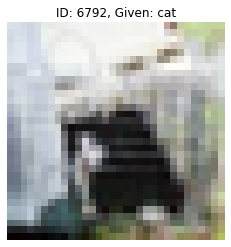

Enter correct label for ID 6792 (ex: 'frog'), or press Enter to keep as 'cat': truck
✅ Updated label to: truck



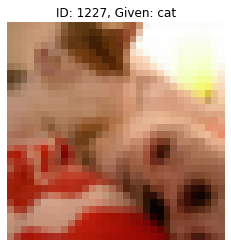

Enter correct label for ID 1227 (ex: 'frog'), or press Enter to keep as 'cat': dog
✅ Updated label to: dog



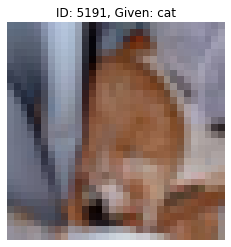

Enter correct label for ID 5191 (ex: 'frog'), or press Enter to keep as 'cat': dog
✅ Updated label to: dog



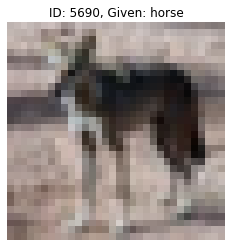

Enter correct label for ID 5690 (ex: 'frog'), or press Enter to keep as 'horse': deer
✅ Updated label to: deer



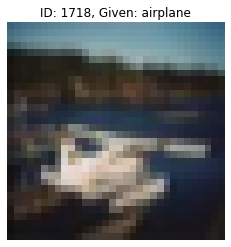

Enter correct label for ID 1718 (ex: 'frog'), or press Enter to keep as 'airplane': ship
✅ Updated label to: ship



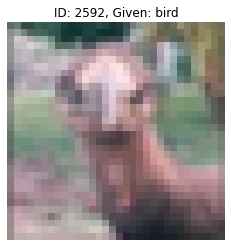

Enter correct label for ID 2592 (ex: 'frog'), or press Enter to keep as 'bird': deer
✅ Updated label to: deer



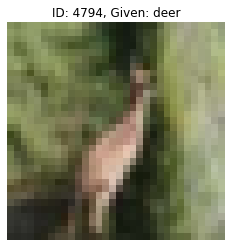

Enter correct label for ID 4794 (ex: 'frog'), or press Enter to keep as 'deer': bird
✅ Updated label to: bird



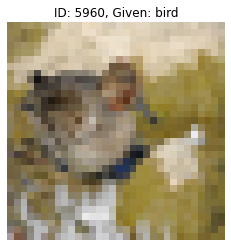

Enter correct label for ID 5960 (ex: 'frog'), or press Enter to keep as 'bird': cat
✅ Updated label to: cat



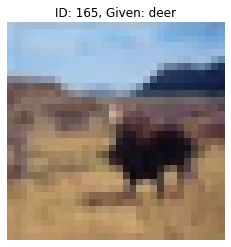

Enter correct label for ID 165 (ex: 'frog'), or press Enter to keep as 'deer': bird
✅ Updated label to: bird



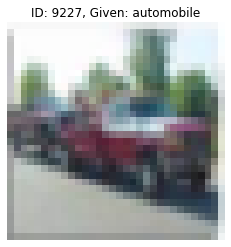

Enter correct label for ID 9227 (ex: 'frog'), or press Enter to keep as 'automobile': truck
✅ Updated label to: truck



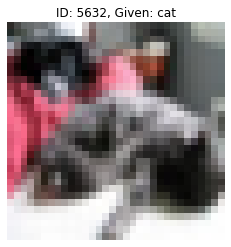

Enter correct label for ID 5632 (ex: 'frog'), or press Enter to keep as 'cat': dog
✅ Updated label to: dog



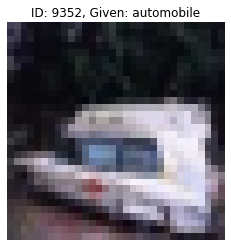

Enter correct label for ID 9352 (ex: 'frog'), or press Enter to keep as 'automobile': truck
✅ Updated label to: truck



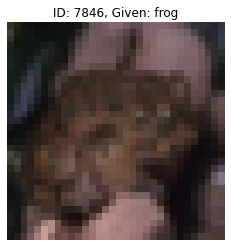

Enter correct label for ID 7846 (ex: 'frog'), or press Enter to keep as 'frog': cat
✅ Updated label to: cat



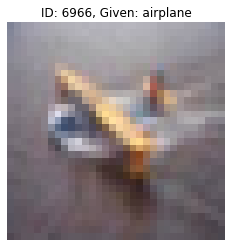

Enter correct label for ID 6966 (ex: 'frog'), or press Enter to keep as 'airplane': ship
✅ Updated label to: ship



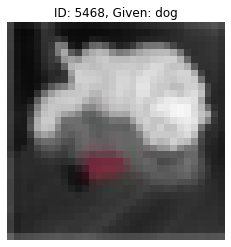

Enter correct label for ID 5468 (ex: 'frog'), or press Enter to keep as 'dog': cat
✅ Updated label to: cat



In [10]:
import numpy as np
from keras.datasets import cifar10

# CIFAR-10 데이터 로드
(_, _), (x_test, y_test) = cifar10.load_data()
y_test = y_test.flatten()

# Cleanlab에서 제공하는 오류 index 목록
error_ids = [2405, 6877, 8058,
            2532, 7657, 1969,
            2804, 6792, 1227,
            5191, 5690, 1718,
            2592, 4794, 5960,
            165, 9227, 5632,
            9352, 7846, 6966,
            5468]  # 원하는 ID만 추출

# 오류 샘플 시각화 및 라벨 수정
import matplotlib.pyplot as plt

corrected_labels = y_test.copy()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for idx in error_ids:
    plt.imshow(x_test[idx])
    current_label = class_names[y_test[idx]]
    plt.title(f"ID: {idx}, Given: {current_label}")
    plt.axis('off')
    plt.show()

    user_input = input(f"Enter correct label for ID {idx} (ex: 'frog'), or press Enter to keep as '{current_label}': ").strip().lower()

    if user_input == "":
        continue
    elif user_input in class_names:
        corrected_labels[idx] = class_names.index(user_input)
        print(f"✅ Updated label to: {user_input}\n")
    else:
        print("❌ Invalid class name. Skipped.\n")


## 2. 하이퍼파라미터 튜닝

In [12]:
pip install keras-tuner

     |████████████████████████████████| 129 kB 5.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 기존 모델 구조 기반 + 하이퍼파라미터 튜닝을 위한 함수로 정의
def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Choice('conv1_filters', [32, 64]), kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        AveragePooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=hp.Choice('conv2_filters', [64, 128]), kernel_size=(3, 3), activation='relu'),
        AveragePooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=hp.Choice('dense_units', [128, 256]), activation='relu'),
        Dropout(rate=hp.Choice('dropout_rate', [0.3, 0.5])),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# KerasTuner 설정
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cifar10_custom_model'
)

# 하이퍼파라미터 튜닝 실행
tuner.search(x_train, y_train, epochs=5, validation_split=0.2, batch_size=64, verbose=1)

# 최적 모델 획득 및 학습
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# 모델 저장
best_model.save("best_cifar10_model")
print("✅ 튜닝된 모델이 SavedModel 형식으로 저장되었습니다.")


Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.6690999865531921

Best val_accuracy So Far: 0.6965000033378601
Total elapsed time: 00h 01m 28s
Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 1.5744 - accuracy: 0.4505 - val_loss: 1.7204 - val_accuracy: 0.4203
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 1.1685 - accuracy: 0.5858 - val_loss: 1.1162 - val_accuracy: 0.6046
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.9849 - accuracy: 0.6510 - val_loss: 1.0174 - val_accuracy: 0.6416
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.8576 - accuracy: 0.6973 - val_loss: 1.1579 - val_accuracy: 0.5999
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.7581 - accuracy: 0.7301 - val_loss: 0.9914 - val_accuracy: 0.6605
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6738 - accuracy: 0.7621 - val_loss: 0.9017 - val_accuracy: 0.6957
Epoch 

### 내용 및 결과

- 5회의 하이퍼 파라미터 조합 시행   
- val_accuracy 69.65% 달성   

## 3. 하이퍼 파라미터 튜닝 실험

|항목	|기존	|변경|
|-|-|-|
|튜너 방식	|RandomSearch	|Hyperband|
|탐색 강도|	max_trials=5	|max_epochs=20 + factor=3 (더 효율적 탐색)|
|에폭 수	|탐색 중 epochs=5	|max_epochs=20 (초기 성능 잡은 후 서서히 정교화)|

In [14]:
from keras_tuner.tuners import Hyperband
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

# 데이터 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 하이퍼모델 정의
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Choice('conv1_filters', [32, 64]), kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        AveragePooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(hp.Choice('conv2_filters', [64, 128]), kernel_size=(3, 3), activation='relu'),
        AveragePooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=hp.Choice('dense_units', [128, 256]), activation='relu'),
        Dropout(rate=hp.Choice('dropout_rate', [0.3, 0.5])),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperband 튜너 설정
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_dir_hyperband',
    project_name='cifar10_tuning_hyperband'
)

# 튜닝 실행
tuner.search(x_train, y_train,
             validation_split=0.2,
             batch_size=64,
             verbose=1)

# 최적 하이퍼파라미터로 모델 재학습
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# 저장
save_path = "best_cifar10_model_hyperband"
best_model.save(save_path)
print(f"✅ 모델 저장 완료: {save_path}")

Trial 21 Complete [00h 00m 23s]
val_accuracy: 0.6945000290870667

Best val_accuracy So Far: 0.7347999811172485
Total elapsed time: 00h 05m 36s
Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 1.6594 - accuracy: 0.4263 - val_loss: 1.9389 - val_accuracy: 0.3752
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 1.2552 - accuracy: 0.5515 - val_loss: 1.3289 - val_accuracy: 0.5315
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 1.0662 - accuracy: 0.6225 - val_loss: 1.4129 - val_accuracy: 0.5144
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.9349 - accuracy: 0.6703 - val_loss: 0.9149 - val_accuracy: 0.6833
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.8334 - accuracy: 0.7064 - val_loss: 1.1424 - val_accuracy: 0.6307
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.7457 - accuracy: 0.7376 - val_loss: 0.9507 - val_accuracy: 0.6885
Epoch

### 내용 및 결과

- 튜너 방식을 효율화하고, 탐색 수도 늘였더니      
- val_accuracy 73.47% 달성   

## 4. 회고

- Hyperband 튜너를 사용해 더 깊고 효율적인 하이퍼파라미터 탐색을 진행했음.
- RandomSearch보다 성능이 높은 조합을 빠르게 찾아내는 데 유리하다는 점을 체감할 수 있었음.
- 아래의 형태로 optimizer 또는 learning rate 도 튜닝 가능하다는 것을 추가 학습하였음
    - optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    - learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
